# Compare Model Performance

In [1]:
%%capture
import sys, os
cwd = os.getcwd()
os.chdir(cwd+"/common")
!python3 -m atari_py.import_roms ../Roms

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
import gym
import numpy as np
import math, random
from wrappers import make_atari, wrap_deepmind, wrap_pytorch
from model import CnnDQNCrop, ConvDuelingDQN
import matplotlib.pyplot as plt
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
import time
import matplotlib.pyplot as plt
from utils import crop_breakout



/home/zhanghao/.local/lib/python3.8/site-packages/ale_py/roms/__init__.py:94: DeprecationWarning: Automatic importing of atari-py roms won't be supported in future releases of ale-py. Please migrate over to using `ale-import-roms` OR an ALE-supported ROM package. To make this warning disappear you can run `ale-import-roms --import-from-pkg atari_py.atari_roms`.For more information see: https://github.com/mgbellemare/Arcade-Learning-Environment#rom-management
  _RESOLVED_ROMS = _resolve_roms()


In [3]:


is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

%matplotlib inline



def test_model(path,model_type="dqn"):
    
    env_id = "Breakout-v4"
    env = wrap_deepmind(gym.make(env_id))
    env = wrap_pytorch(env)
    
    
    
    if model_type == "dqn":
        model = CnnDQNCrop(env.action_space.n)
    else:
        model = ConvDuelingDQN(env.action_space.n)
    
    if torch.cuda.is_available():
        model = model.cuda()
    model.load_state_dict(torch.load(path))

    state = env.reset()
    img = plt.imshow(env.render(mode='rgb_array'))

    frame_queue = [np.squeeze(np.array(state),axis = 0)]
    total_reward = 0
    # img = plt.imshow(crop_breakout(np.array(frame_queue))[0])

    for i in range(10000000):

        if len(frame_queue)!=4:
            action = random.choice(range(env.action_space.n))
            next_state, reward, done, _ = env.step(action)
            frame_queue.append(np.squeeze(np.array(next_state),axis = 0))
        else:
            state_4frames = np.array([frame_queue[0],frame_queue[1],frame_queue[2],frame_queue[3]])
            action = model.act(crop_breakout(state_4frames),0)
            next_state, reward, done, _ = env.step(action)
            frame_queue.pop(0)
            frame_queue.append(np.squeeze(np.array(next_state),axis = 0))

        total_reward += reward


        # img.set_data(crop_breakout(np.array(frame_queue))[0]) 
        img.set_data(env.render(mode='rgb_array')) 
        plt.axis('off')
        display.display(plt.gcf())
        display.clear_output(wait=True)
        # state, reward, done, _ = env.step(action.cpu().item())
        time.sleep(0.01)
        if done:
            print("Total Frames: "+str(i))
            print("Total Reward: "+str(total_reward))
            
            break 
    
    env.close()

        


## Basic DQN

Total Frames: 110
Total Reward: 2.0


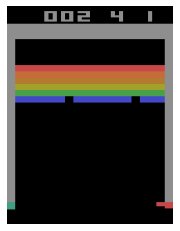

In [4]:
test_model(cwd+"/models/dqn_breakout_crop.pt")

## DQND

Total Frames: 224
Total Reward: 5.0


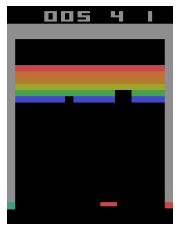

In [16]:
test_model(cwd+"/models/dqnd_breakout_crop.pt","dqnd")

## DDQN

In [6]:
test_model(cwd+"/models/ddqn.pt")

RuntimeError: Error(s) in loading state_dict for CnnDQNCrop:
	Missing key(s) in state_dict: "features.6.weight", "features.6.bias". 
	size mismatch for features.0.weight: copying a param with shape torch.Size([32, 4, 8, 8]) from checkpoint, the shape in current model is torch.Size([128, 4, 3, 3]).
	size mismatch for features.0.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for features.2.weight: copying a param with shape torch.Size([64, 32, 4, 4]) from checkpoint, the shape in current model is torch.Size([64, 128, 3, 3]).
	size mismatch for fc.0.weight: copying a param with shape torch.Size([512, 3136]) from checkpoint, the shape in current model is torch.Size([512, 2688]).

## Pioritized Replay Buffer

In [ ]:
test_model(cwd+"/models/dqn_per.pt")